# <center><font color='orange'> Модель ML для проверки достоверности рейтинга отеля </font></center>

### <font color='green'>**Цель проекта:**</font>
Создать модель ML для предсказания рейтинга отеля на booking.com

Для оценки качества модели (точности прогнозов) будет использоваться метрика MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. Если MAPE = 11.4 %, то это говорит о том, что ошибка составила 11.4 % от фактических значений.

$$ MAPE = 100 \% * 1/n \sum_{i=1}^{n} \frac{\left| ytrue_{i} - ypred_{i} \right|}{\left| ytrue_{i} \right|} $$ 
$ytrue_{i}$ - фактические значения прогноза, 
$ypred_{i}$ — предсказанные.

Проект будет считаться успешным, если MAPE будет равна 13,5% или меньше.

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from geopy.geocoders import Nominatim
import re

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

#### <font color='green'>**1. Знакомство с данными.**</font>

In [3]:
# загружаем данные, выведем несколько строк, чтобы посмотреть, из каких признаков состоит датасет
hotels = pd.read_csv('data/hotels.zip')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


**Итак, датасет об отелях представлен 17 признаками:**
- *hotel_address*: адрес отеля;
- *additional_number_of_scoring*: некоторые гости отеля ставили только оценки без написания отзыва. Данное число указывает на количество таких оценок(без отзыва); 
- *review_date*: дата, когда рецензент(гость отеля) оставил свой отзыв о проживании;
- *average_score*: средняя оценка отеля, рассчитанная на основе комментариев (отзывов) за последний год;
- *hotel_name*: название отеля;
- *reviewer_nationality*: из какой страны рецензент(гость отеля);
- *negative_review*: негативный отзыв гостя об отеле;
- *review_total_negative_word_counts*: количество слов в негативном отзыве;
- *total_number_of_reviews*: общее количество отзывов об отеле;
- *positive_review*: положительный отзыв гостя об отеле;
- *review_total_positive_word_counts*: количество слов в положительном отзыве;
- *total_number_of_reviews_reviewer_has_given*: количество отзывов, данных рецензентом в прошлом;
- *reviewer_score*: оценка гостя, данная отелю на основе его/ее опыта;
- *tags*: теги, которыми гость отметил отель;
- *days_since_review*: количество дней с момента написания отзыва, отсчет с последней даты, которая представлена в датасете;
- *lat*: географическая широта отеля;
- *lng*: географическая долгота отеля.

Ключевым признаком для нас является оценка гостя **reviewer_score**, наша модель будет предсказывать на основе отобранных нами признаков, какую оценку поставит гость отелю.


In [4]:
# посмотрим на размер датасета, имеются ли пропуски и какими типами данных представлены признаки
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

<font color='orange'>**Вывод:**</font>\
В датасете есть, как числовые признаки, так и признаки типа *object*, которые нам предстоит преобразовать или удалить перед созданием нашей модели.\
Наблюдаем небольшое количество пропусков в географических данных отеля.

**Для начала посмотрим на основные метрики признаков.**

In [5]:
print(hotels.describe())
hotels.describe(include='object')

       additional_number_of_scoring  average_score  \
count                 386803.000000  386803.000000   
mean                     498.246536       8.397231   
std                      500.258012       0.547881   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      342.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       review_total_negative_word_counts  total_number_of_reviews  \
count                      386803.000000            386803.000000   
mean                           18.538988              2743.992042   
std                            29.703369              2316.457018   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                           

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


<font color='orange'>**Вывод:**</font>\
Предполагаем, что признаки *additional_number_of_scoring*, *total_number_of_reviews*, *total_number_of_reviews_reviewer_has_given*, 
*review_total_positive_word_counts*, *review_total_negative_word_counts* содержат выбросы, учитывая большой отрыв от 75 -квантиля.\
Самими распространнеными отзывами являются отзывы 'наоборот': No Negative, No Positive.\
Абсолютным большинством гостей являются англичане, а самый популярный отель расположен в Великобритании, Лондоне.

#### <font color='green'>**2. Очистка данных.**</font>

Нормализацию выбросов мы произведем после проектирования новых признаков.

Мы наблюдали пропуски в двух признаках: *lat* и *lng*.\
Заполним их, воспользовавшись библиотекой geopy, так как у нас есть признак адреса отеля, по которому мы сможем получить данные.

In [6]:
# создадим список адресов отелей, в данных которых отсутствует широта и долгота(указано 'NaN')
list_address= hotels['hotel_address'].loc[(hotels.lat.isna())&(hotels.lng.isna())]
list_address= list(list_address.unique())      # оставляем уникальные значения в списке
print('Список адресов отелей, имеющих пропуски в географических широте и долготе:')
for address in list_address:
    print(address)
print()
print('Количество адресов')
print(len(list_address))

Список адресов отелей, имеющих пропуски в географических широте и долготе:
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria
23 Rue Damr mont 18th arr 75018 Paris France
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria
4 rue de la P pini re 8th arr 75008 Paris France
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria
Bail n 4 6 Eixample 08010 Barcelona Spain
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria
Paragonstra e 1 11 Simmering 1110 Vienna Austria
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria
20 Rue De La Ga t 14th arr 75014 Paris France
Hasenauerstra e 12 19 D bling 1190 Vienna Austria
Sep lveda 180 Eixample 08011 Barcelona Spain
Pau Clar s 122 Eixample 08009 Barcelona Spain
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria

Количество адресов
17


In [7]:
'''
На основе адресов создадим словарь coordinates, где по ключу-адресу будет указаны широта и долгота.
Для этого создадим объект геокодера Nominatim из библиотеки geopy, по которому и будем передавать адрес из нашего списка.
Из адреса мы будем отделять только часть, содержащую страну, город, индекс и район, 
т.к. некоторые адреса имеют лексические ошибки в деталях улицы и не позволят нам получить данные.
'''
# подготовим пустой словарь
coordinates = dict()
# создаем функцию
def get_coordinates(list_address):
    for address in list_address:
        # создаем объект геокодера Nominatim
        geolocator = Nominatim(user_agent="geoapiUseragent")
        # адрес-строку, который нужно геокодировать, преобразуем в список, чтобы отделить нужную информацию
        address_ = address.split()
        # вызываем метод geocode объекта геокодера для геокодирования адреса
        location = geolocator.geocode(' '.join(address_[-4:]))  # список из района, индекса, города и страны объединяем в строку (метод join)
        # по атрибутам latitude и longitude получаем необходимые данные
        coordinates[address] = [round(location.latitude, 6), round(location.longitude, 6)]
    # возвращаем заполненный словарь
    return coordinates
# применим созданную функцию к списку адресов
coordinates = get_coordinates(list_address)
coordinates

{'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.214955, 16.302153],
 '23 Rue Damr mont 18th arr 75018 Paris France': [48.887022, 2.347832],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.210852,
  16.34736],
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.225073,
  16.358398],
 '4 rue de la P pini re 8th arr 75008 Paris France': [48.887022, 2.347832],
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': [48.204835, 16.370208],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.200638, 16.426895],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.393689, 2.163655],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.225073, 16.358398],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.202547,
  16.384616],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': [48.163109, 16.458013],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.225073,
  16.358398],
 '20 Rue De La Ga t 14th arr 75014 Paris Fra

In [8]:
def fill_coordinates(row):
    '''
    Функция заполнения пропущенных значений в признаках lat и lng.
    Каждую строку этих столбцов, где есть пропуски, заполняем координатами из созданного словаря coordinates по соответствующему 
    ключу-адресу: 
    первое значение [0] соответствует широте lat, второе [1] - долготе lng
    '''
    # если значение в столбце широты равно NaN
    if pd.isna(row.lat):
        row.lat = coordinates[row.hotel_address][0]
        row.lng = coordinates[row.hotel_address][1]
    return row
# применим функцию к датасету
hotels = hotels.apply(lambda row: fill_coordinates(row), axis=1)
# проверим, что данные заполнились правильно
display(hotels.loc[hotels['hotel_address']=='4 rue de la P pini re 8th arr 75008 Paris France'].head(2))
hotels.loc[hotels['hotel_address']=='Hasenauerstra e 12 19 D bling 1190 Vienna Austria'].head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,1/5/2016,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,0,1,8.8,"[' Leisure trip ', ' Couple ', ' Executive Dou...",576 day,48.887022,2.347832
10414,4 rue de la P pini re 8th arr 75008 Paris France,172,1/31/2017,8.8,Maison Albar Hotel Paris Op ra Diamond,Australia,We asked for help from the reception to recom...,25,1524,Great location English speaking staffs make t...,48,11,9.6,"[' Leisure trip ', ' Family with young childre...",184 day,48.887022,2.347832


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
7635,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,37,7/7/2017,8.6,Hotel Park Villa,Netherlands,With temperatures of 30 degrees it was quite ...,31,564,Breakfast was really good really tasty and th...,79,11,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",27 days,48.204835,16.370208
17511,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,37,2/14/2016,8.6,Hotel Park Villa,Austria,No Negative,0,564,Everything from clean and comfortable rooms t...,11,7,10.0,"[' Family with young children ', ' Standard Do...",536 day,48.204835,16.370208


**Проверим датасет на наличие полных дубликатов и удалим их.**

In [9]:
duplicates = hotels[hotels.duplicated(subset = list(hotels.columns))]
print('Число найденных дубликатов:', duplicates.shape[0])

Число найденных дубликатов: 307


In [10]:
# удалим полные дубликаты в значениях датасета
hotels = hotels.drop_duplicates(subset = list(hotels.columns))

In [11]:
# убеждаемся, что теперь в датасете нет пропусков, посмотрим на размер после удаления дубликатов
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

#### <font color='green'>**3. Разведывательный анализ.**</font>

**3.1. Анализ признака адрес отеля *hotel_address*.**

In [12]:
# посмотрим на адреса: какая информация и последовательность
hotels.hotel_address.head(10).to_list()   # метод to_list() для выведения информации в удобном формате списка

['Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom',
 '130 134 Southampton Row Camden London WC1B 5AF United Kingdom',
 '151 bis Rue de Rennes 6th arr 75006 Paris France',
 '216 Avenue Jean Jaures 19th arr 75019 Paris France',
 'Molenwerf 1 1014 AG Amsterdam Netherlands',
 'Via Mecenate 121 20138 Milan Italy',
 '97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom',
 'Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria',
 '190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom',
 'Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom']

Признак *hotel_address* содержит информацию о стране, что представляет для нас интерес, так как имеется признак национальности гостя и мы можем посмотреть, влияет ли на оценку, что гость является резидентом страны, в которой он воспользовался услугами отеля или нет.

**Преобразуем признак *hotel_address* в признак страны отеля *country_of_hotel*.**\
Страна в адресе отеля указана на последнем месте.

Страны, в которых находятся отели, и количество отелей соотвественно


United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: country_of_hotel, dtype: int64

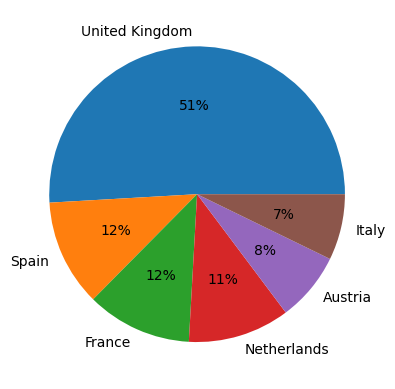

In [13]:
# создаем новый столбец, пока заполняем его значения нулем 0
hotels['country_of_hotel'] = 0
# функция для извлечения страны из адреса отеля
def get_city_country(row):
    # каждое значение-строку адреса отеля разделяем, формируем список с помощью функции str.split()
    name = row.hotel_address.split()
    # если последнее значение в списке соотвествует 'Kingdom', то значение страны - 'United Kingdom' (Великобритания)
    if name[-1] == 'Kingdom':
        row.country_of_hotel ='United Kingdom'
    # все остальные соотвествуют названию страны и их сохраняем в новый признак country_of_hotel
    else:
        row.country_of_hotel = name[-1]
    return row

# применим созданную функцию к нашему датасету   
hotels = hotels.apply(lambda row: get_city_country(row), axis=1)

# посмотрим, отели каких стран представлены в нашем датасете
print('Страны, в которых находятся отели, и количество отелей соотвественно')
display(hotels['country_of_hotel'].value_counts())
# отобразим соотношение в количестве отелей между странами 
ratio_of_countries = hotels['country_of_hotel'].value_counts()
plt.pie(ratio_of_countries, labels = ratio_of_countries.index, autopct = '%.0f%%')
plt.show()

<font color='orange'>**Вывод:**</font>\
Мы видим, что всего шесть стран представляют отели в нашем датасете и половина (51%) отелей находится в Великобритании.
Далее мы сможем провести тесты и проверить, влияет ли страна на оценку.
На данном этапе новый признак позволит нам преобразовать признак национальности гостей отеля *reviewer_nationality*

**3.2 Преобразование признака *reviewer_nationality*.**

Если страна рецензента совпадает со страной отеля, закодируем его нулем 0, если гость приехал из другой страны, то - единицей 1.

In [14]:
# для преобразования признака уберем лишние пробелы в начале или конце строки с помощью функции str.strip()
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
# создаем новый признак local_reviewer (гость - резидент или нерезидент страны отеля)
hotels['local_reviewer'] = hotels.apply(lambda row: 0 if row['country_of_hotel'] == row['reviewer_nationality'] else 1, axis=1)

,local_reviewer,country_of_hotel,reviewer_nationality
0,0,United Kingdom,United Kingdom
1,0,United Kingdom,United Kingdom
2,1,France,China
3,1,France,United Kingdom
4,1,Netherlands,Poland


Количество резидентов и нерезидентов среди гостей отелей: 0 - резидент, 1 - нерезидент


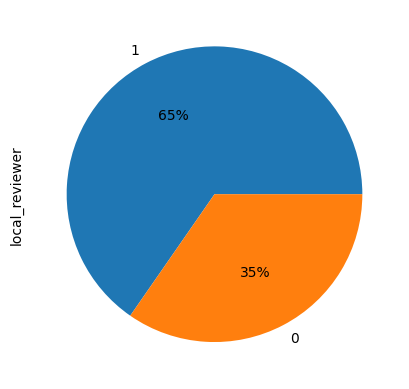

In [15]:
# проверяем, что данные преобразовались правильно
display(hotels[['local_reviewer', 'country_of_hotel', 'reviewer_nationality']].head())
# посмотрим соотношение резидентов и нерезидентов среди гостей отелей
print('Количество резидентов и нерезидентов среди гостей отелей: 0 - резидент, 1 - нерезидент')
hotels['local_reviewer'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Мы извлекли необходимую нам для анализа информацию о стране из адреса отеля и преобразовали признак национальности,
удалим ненужные теперь столбцы *hotel_address*, *reviewer_nationality*

In [16]:
hotels.drop(['hotel_address', 'reviewer_nationality'], axis=1, inplace = True)
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country_of_hotel,local_reviewer
0,581,2/19/2016,8.4,The May Fair Hotel,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,0
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,0


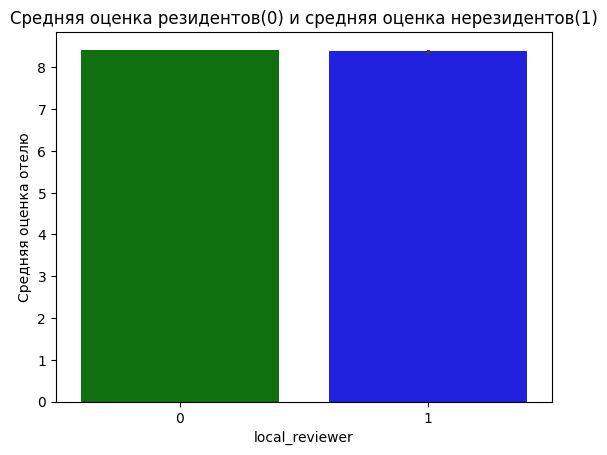

In [17]:
# отобразим на столбчатой диаграмме среднюю оценку гостей среди резидентов и нерезидентов
barplot = sns.barplot(hotels, x='local_reviewer', y='reviewer_score', orient='v', palette = ['green', 'blue'])
barplot.set(ylabel='Средняя оценка отелю')
barplot.set_title('Средняя оценка резидентов(0) и средняя оценка нерезидентов(1)');

<font color='orange'>**Вывод:**</font>\
~ 65% гостей отелей - нерезиденты страны отеля.
По графику не заметно, чтобы национальность влияла на оценку, которую оставляет гость после посещения отеля.

**3.3 Преобразование признака даты *review_date*.**

В датасете есть признак 'days_since_review', который содержит информацию о количестве дней с момента написания отзыва.\
Поэтому из признака 'review_date' мы можем извлечь информацию о месяце, о сезоне, когда гость посетил отель, мы оставим только признак сезонности и исследуем, влияет ли время года на отзыв об отеле.

In [18]:
# преобразуем признак в формат datetime и извлечем месяц из даты с помощью атрибута dt.month
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month
hotels[['month', 'review_date']].head(3)

,month,review_date
0,2,2016-02-19
1,1,2017-01-12
2,10,2016-10-18


Посмотрим, в какие сезоны чаще всего посещаются отели на основе даты отзыва рецензента

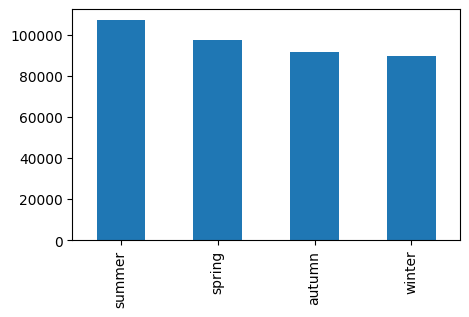

In [19]:
# создаем новый признак season, пока со значениями ноль 0
hotels['season'] = 0
# функция разбивки признака month по сезонам
def get_season(row):
    if row == 12 or row <= 2:
        return 'winter'
    elif row >= 3 and row <= 5:
        return 'spring'
    elif row >= 6 and row <= 8:
        return 'summer'
    elif row >= 9 and row <= 11:
        return 'autumn'
# применим функцию к столбцу month
hotels['season'] = hotels['month'].apply(get_season)
hotels.season.value_counts().plot(kind = 'bar', figsize=(5,3));

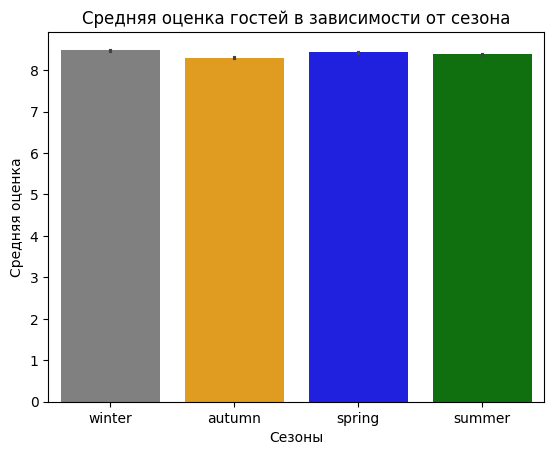

In [20]:
# отобразим на столбчатой диаграмме, есть ли влияние сезонности на оценку отелю от гостя
barplot = sns.barplot(data = hotels, x = 'season', y = 'reviewer_score', palette=['grey', 'orange', 'blue', 'green'])   
barplot.set(xlabel='Сезоны', ylabel='Средняя оценка')
barplot.set_title('Средняя оценка гостей в зависимости от сезона'); 

In [21]:
# после извлечения сезонности можно удалить признак даты review_date и промежуточный признак month
hotels.drop(['review_date', 'month'], axis=1, inplace = True)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country_of_hotel,local_reviewer,season
0,581,8.4,The May Fair Hotel,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,0,winter
1,299,8.3,Mercure London Bloomsbury Hotel,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,0,winter


In [22]:
# преобразуем признак 'days_since_review' в числовой, удалив текстовую часть 'day'	
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['days_since_review'].head()

0    531
1    203
2    289
3    681
4    516
Name: days_since_review, dtype: int64

<font color='orange'>**Вывод:**</font>\
Распределение популярности отелей по сезонам предсказуемо: самая низкая - зимой, самая высокая - летом, но стоит отметить, что распределение равномерное, мы не наблюдаем больших скачков между сезонами.\
На данном этапе исследования мы не видим, чтобы время года посещения отеля как-то бы отражалось на оценке, средняя оценка практически одинакова по всем сезонам.

**3.4 Преобразование признаков *negative_review* (негативный отзыв) и *positive_review* (положительный отзыв).**

По опыту мы знаем, что часто, если нет негативного впечатления об отеле, гости в анкете заполняют данный пункт с указанием, что негатива нет, все хорошо и т.п., поэтому мы постараемся определить, какие отзывы действительно являются негативными, а какие нет.
Аналогично и с положительными отзывами, гости могут в данном пункте записать, что ничего не понравилось, ничего положительного.


In [23]:
'''
Чтобы нам было проще анализировать отзывы, мы ограничимся первыми пятью словами, 
обычно по первым словам понятно, какого оттенка отзыв.
Создадим функцию для отделения первых пяти слов в отзыве.
'''
def cut_review(row):
    row = row.strip()
    row = row.split()[0:5]
    row = ' '.join(row)
    return row
# применим функцию к признаку negative_review
hotels['negative_review'] = hotels['negative_review'].apply(cut_review)
# создадим список уникальных негативных отзывов и изучим его
list_negative = list(hotels['negative_review'].unique())
# из-за большой длины списка не выводим его в данном ноутбуке
hotels['negative_review'].value_counts().head(10)

No Negative                95833
Nothing                    13885
nothing                     1877
None                         871
N A                          818
                             606
The room was very small      443
Nothing really               434
N a                          391
All good                     366
Name: negative_review, dtype: int64

In [24]:
list_negative_samples = ['No Negative', 'Nothing', 'nothing', 'None', 'N A', 'Nothing it was lovely', 'Leaving', 'Nothing hotel refurb great',
                 'Nothing This hotel has everything', 'Nothing to dislike', 'There is nothing to dislike', 
                 'Nothing everything was perfect', 'all satisfactory but nothing special', 'weather', 'nothing to complain', 
                 'It was really lovely What', 'NA', 'Nope', 'can t really complain', 'absolutely nothingA', 'No dislikes', 'all great',
                 'Nothing to fault', 'N a', 'NIL', 'Nothing Everything was fine', 'Nothing it was all great', 
                 'Everything nothing I disliked', 'Could not be better', 'Nothing smarties everyday', 'nothing really', 
                 'Nothing I can think of', 'Nothing Everything was immaculate', 'Nothing all excellent', 'None', '', 'Noth ng', 'na', 
                 'No complaints', 'All very good', 'Mothing', 'every thing ok', 'No problems', 'All good', 
                 'Nothing not to like', 'Nothing negative to say about', 'Nothing I did not like', 'Nothing at I We honestly', 
                 'No negative comments', 'nothing at all', 'Liked everything', 'More than average', 'No comment everything was great', 
                 'Nothing to fault Everything was', 'Everything was perfect about the', 'Nothing that I can think', 
                 'I thought it was excellent', 'Did not have a bad', 'Everything was good Prices for', 'I liked everything it s',
                 'Nothing I can think of', 'There was nothing I didn', 'Nothing as we waited well' ]
'''
По факту изучения списка мы заметили, что гости практически всегда описывают отсутствие негативного впечатления об отеле 
через слово 'nothing', поэтому все отзывы, которые содержат данное слово определим за ноль 0, также все сокращенные обозначения 
по типу 'N A', 'Nope' и отзывы с положительным контекстом по типу 'All good', 'No complaints'.
Создадим шаблон поиска regex со всеми этими выражениями для разбиения признака на две категории: 
0 - нет негативного впечатления, 1 - действительный негативный отзыв.
Несмотря на то, что наше преобразование получится довольно условным, так как при написании отзыва могут быть лексические 
и синтаксические ошибки и учесть их все, а также найти все положительные выражения из большого массива данных очень трудоемко, 
мы постараемся условно выделить действительно негативные отзывы на основе полученного изучения.
'''
# шаблон НЕ негативных отзывов
pattern = '(Nothing|Mothing|nothing to complain|noth ng|nothingA|None|Nope|N A|NA|N a|NIL|It was really lovely|All good|\
    all good|I liked everything|Everything was good|everything was good|all great|everything was great|all was great|\
        Liked everything|I liked everything|All very good|every thing ok|everything ok|it was excellent|all very good|\
            everything was perfect|Everything was perfect|all excellent|No Negative|no negative|No negative|\
                No problems|no problems|No complaints|no complains|No dislikes|no dislikes|nothing at all)'

# функция преобразования отзыва, применим шаблон к значениям признака 
def convert_review(row, regex):
    row = re.findall(regex, row)   # функция findall(regex, str) модуля re ищет совпадение выражения regex в строке str
    if row  == []:              # если совпадений нет, возвращается пустой список, это означает, что отзыв - действительно негативный 
        row = 1
    else:
        row = 0
    return row

# применим созданую функцию к признаку negative_review, создадим новый категориальный признак negative_review_new
hotels['negative_review_new'] = hotels['negative_review'].apply(lambda x: convert_review(x, pattern))
# проверим правильность нашего преобразования
display(hotels[['negative_review_new', 'negative_review']].head(20))
print("Количество действительных негативных отзывов и ложнонегативных: 1 - негативный, 0 - негативного нет")
hotels['negative_review_new'].value_counts()

,negative_review_new,negative_review
0,1,Leaving
1,1,poor breakfast
2,1,No kettle in room
3,0,No Negative
4,1,Torn sheets
5,0,Nothing
6,0,Nothing it was lovely
7,1,The communal areas are a
8,1,undergoing refurbishment no tea coffer
9,1,I advised it was for


Количество действительных негативных отзывов и ложнонегативных: 1 - негативный, 0 - негативного нет


1    265414
0    121082
Name: negative_review_new, dtype: int64

Произведем аналогичные действия с признаком positive_review.

In [25]:
# применим функцию для отделения первых пяти слов отзыва
hotels['positive_review'] = hotels['positive_review'].apply(cut_review)
# создаем лист уникальных отзывов
list_positive = list(hotels['positive_review'].unique())
# из-за большой длины списка, не выводим в ноутбуке, можете запустить его индивидуально и изучить
hotels['positive_review'].value_counts().head(10)

No Positive                     26863
Location                         7487
Everything                       2146
location                         1293
Nothing                          1099
Great location                   1087
The location                      980
Good location                     903
The location of the hotel         813
The staff were very friendly      738
Name: positive_review, dtype: int64

In [26]:
list_positive = ['No Positive', 'Nothing', 'Nothing Awful place It s', 'NA', 'Nothing was too much trouble', 'X',
                 'The staff couldn t hAve', 'Not a lot', 'Didn t eat there', 'Nothing m', 'I did not like the', 
                 'Nothing extraordinary', 'Just its closed to Evil', 'I m sorry I can', ]
'''
Аналогично закодируем положительные оценки гостей о посещении отеля.
Заметим, что слово 'nothing' также отражает противоположность положительному мнению.
Сразу видно, что признак positive_review более точно отражает наличие действительных положительных отзывов.
'''
# шаблон выражений
pattern2 = '(No Positive|No positive|no positive|Nothing|NA|N a|N A|X|I did not like|I didnt like)'

# применим функцию нахождения выражений из шаблона и преобразование в категорию
hotels['positive_review_new'] = hotels['positive_review'].apply(lambda x: convert_review(x, pattern2))

display(hotels[['positive_review_new', 'positive_review']].head(20))
print('Количество действительных положительных отзывов и ложноположительных')
hotels['positive_review_new'].value_counts()

,positive_review_new,positive_review
0,1,Staff were amazing
1,1,location
2,0,No Positive
3,1,Friendly staff quiet comfortable room
4,1,The staff was very friendly
5,1,Very nice hotel Price is
6,1,Very central location 2 minutes
7,1,The location is good for
8,1,staff very good location wonderful
9,0,No Positive


Количество действительных положительных отзывов и ложноположительных


1    357386
0     29110
Name: positive_review_new, dtype: int64

In [27]:
# удалим преобразованные признаки 'positive_review' и 'negative_review'
hotels.drop(['positive_review', 'negative_review'], axis = 1, inplace=True)

<font color='orange'>**Вывод:**</font>\
Проанализировав признаки *positive_review* и *negative_review*, мы смогли закодировать их по принципу действительно негативного и ложнонегативного и аналогично действительно положительного и ложноположительного отзыва, преобразовав два признака в числовые категориальные, мы сможем их использовать в нашей модели, если они окажутся значимыми для ее точности. 

**3.5 Изучение признака *tags* (теги, которые гость поставил отелю).**

In [28]:
# посмотрим, каким образом представлена информация о тегах
display(hotels.tags.head(3).to_list())
# создадим функцию, разделяющую каждую строку-значение столбца на отдельные теги
def get_count_tags(row):
    row = row.replace('[', '').replace(']', '').replace("'", '')   # очищаем строку от лишних кавычек, скобок
    tags = row.strip().split(' ,  ')   # удаляем пробелы в начале и конце строки и разделяем строки по запятым, разделяющим теги
    return tags

# создаем копию датафрейма hotels
hotels_tags = hotels.copy()
# применим созданную функцию к копии
hotels_tags.tags = hotels_tags['tags'].apply(get_count_tags)
# применим функцию explode() для отделения каждого элементы списка(тег) в отдельную строку
hotels_tags = hotels_tags.explode('tags')

print('Количество уникальных тегов')
print(hotels_tags['tags'].nunique())
hotels_tags['tags'].value_counts().head(10)

["[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']"]

Количество уникальных тегов
2368


Leisure trip                      313353
Submitted from a mobile device    230608
Couple                            189046
Stayed 1 night                    145296
Stayed 2 nights                   100176
Solo traveler                      81166
Stayed 3 nights                    71940
Business trip                      61934
Group                              49057
Family with young children         45810
Name: tags, dtype: int64

<font color='orange'>**Вывод:**</font>\
Причина посещения отеля, количество дней в отеле, проживание с семьей, парой или одному, конечно, влияет на оценку, но данный признак, содержащий очень полезную информацию, мы исключим, так как анализ потребует много времени и создания большого количества новых признаков, данный признак является очень информативным, но без преобразования он уникален.

In [29]:
hotels.drop('tags', axis = 1, inplace=True)
hotels.shape

(386496, 16)

**3.6 Преобразование признака *hotel_name* (название отеля).**

Обычно в названии отеля содержится тип отеля, например, это отель, гостевой дом, бутик-отель, апартаменты, роял отель или известный бренд, как hilton.\
Мы преобразуем названия отелей в список и проанализируем его, чтобы найти, какие типы отелей встречаются в нашем датасете.\
После преобразуем данный признак в новый: тип отеля (*type_hotel*).

In [30]:
# преобразование значения-строки столбца hotel_name в отдельные слова
names_of_hotels = hotels['hotel_name'].apply(lambda name: name.strip().lower().split()).explode()
names_of_hotels = pd.Series(names_of_hotels)
# создаем список с уникальными словами
list_of_hotels = list(names_of_hotels.unique())
# изучить список можно отдельно
names_of_hotels.value_counts().head(10)

hotel        176142
london       103139
the           43922
park          32958
amsterdam     29968
hilton        26710
by            20267
plaza         17366
paris         16321
inn           13831
Name: hotel_name, dtype: int64

hotel                177687
other                132082
hilton_marriott       27867
park                  26826
plaza_palace          11155
royal_grand            4960
suites_apartments      3690
guesthouse             1728
mini_boutique           501
Name: type_hotel, dtype: int64

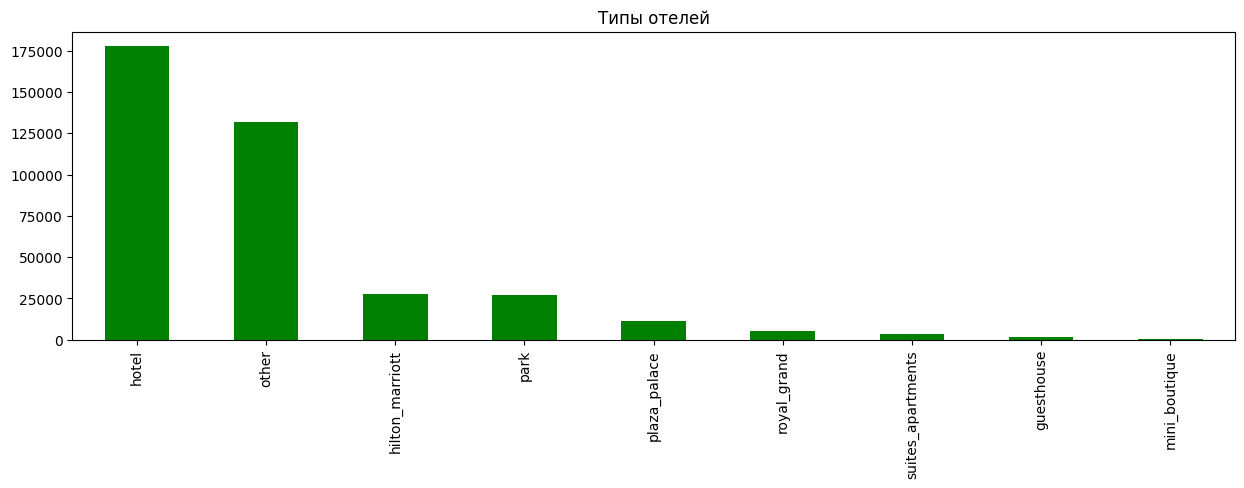

In [31]:
# просмотрев список, мы нашли слова, характеризующие тип отеля
type_hotels = ['hotel', 'hotels', 'park', 'parkhotel', 'plaza', 'palace', 'palazzo', 'ambassador', 'royale', 'royal', 'grand', 
               'hilton', 'radisson', 'marriott', 'sheraton', 'suites', 'suite', 'appartements', 'appartement', 'apartments', 'condes',
               'boutique', 'boutiquehotel', 'minihotel', 'mimi', 'guesthouse', 'house']
# создаем функцию
def get_type_hotels(row):
    '''
    Функция преобразования каждой строки-значения в тип отеля.
    Если значение из списка type_hotels встречается в строке столбца, то заменяем строку за тип,
    если в строке-значении столбца нет совпадений со значениями из списка, определяем как 'other'
    Функция возвращает преобразованные значения.
    '''
    row = row.strip().lower().split()
    for type in type_hotels:
        if type in row:
            return type
    return 'other'

'''По списку type_hotels понятно, что некоторые типы - это можественное число, а некоторые можно объединить в одну категорию.'''

# данная функция объединяет типы по категориям, сокращая количество типов
def get_category_hotels(row):
    if row == 'hotel' or row == 'hotels':
        return 'hotel'
    elif row == 'park'or row == 'parkhotel':
        return 'park'
    elif row == 'plaza' or row == 'palace' or row == 'palazzo':
        return 'plaza_palace'
    elif row == 'ambassador' or row == 'royale' or row == 'royal' or row == 'grand':
        return 'royal_grand'
    elif row == 'hilton' or row == 'radisson' or row == 'marriott' or row == 'sheraton':
        return 'hilton_marriott'
    elif row == 'suites' or row == 'suite' or row == 'appartements' or row == 'appartement' or row == 'apartments' or row == 'condes':
        return 'suites_apartments'
    elif row == 'boutique' or row == 'boutiquehotel' or row == 'mimi' or row == 'minihotel':
        return 'mini_boutique'
    elif row == 'guesthouse' or row == 'house':
        return 'guesthouse'
    elif row == 'other':
        return 'other'

# применим обе функции к признаку hotel_name, преобразовав его в новый признак type_hotel
hotels['type_hotel'] = hotels['hotel_name'].apply(get_type_hotels)
hotels['type_hotel'] = hotels['type_hotel'].apply(get_category_hotels)

# посмотрим по категориям количество отелей и отобразим на столбчатой диаграмме
display(hotels['type_hotel'].value_counts())
hotels['type_hotel'].value_counts().plot(kind = 'bar', figsize=(15,4), color=['green'], title = 'Типы отелей');


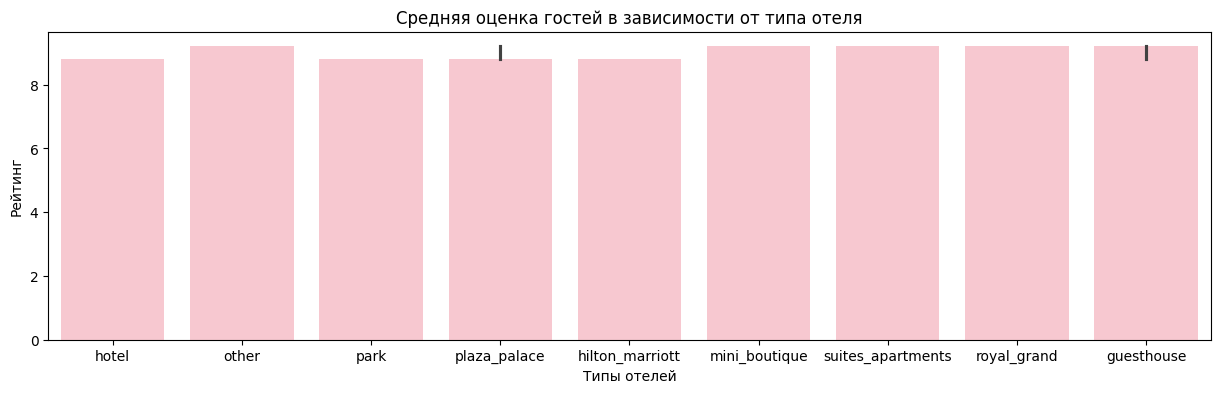

In [32]:
# отобразим на столбчатой диаграмме, есть ли влияние типа отеля на рейтинг отеля
fig = plt.subplots(figsize=(15, 4))
barplot = sns.barplot(data = hotels, x = 'type_hotel', y = 'reviewer_score', estimator = 'median', color = 'pink')   
barplot.set(xlabel='Типы отелей', ylabel='Рейтинг')
barplot.set_title('Средняя оценка гостей в зависимости от типа отеля'); 

<font color='orange'>**Вывод:**</font>\
Мы смогли выделить условно 8 типов отелей и 1 неизвестный, так как в названии отеля не отражался тип отеля.\
Посмотрев на медианный рейтинг по типам отелей, можем отметить, что рейтинг примерно у всех отелей одинаков и высок.
Преобразовав признак hotel_name, можем удалить его из датасета.

In [33]:
# удаляем признак hotel_name
hotels.drop('hotel_name', axis=1, inplace=True)
# посмотрим, какие признаки теперь содержит наш преобразованный датасет
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   review_total_negative_word_counts           386496 non-null  int64  
 3   total_number_of_reviews                     386496 non-null  int64  
 4   review_total_positive_word_counts           386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 6   reviewer_score                              386496 non-null  float64
 7   days_since_review                           386496 non-null  int64  
 8   lat                                         386496 non-null  float64
 9   lng                                         386496 non-null  float64
 

#### <font color='green'>**4. Кодирование признаков.**</font>

Категориальные признаки страны отеля *country_of_hotel*, сезона *season* и типа отеля *type_hotel* являются номинальными и немногочисленными, к ним применимо однократное кодирование One-Hot-Encoding.
Мы применим функцию Pandas get_dummies() однократного кодирования.

In [34]:
hotels = pd.get_dummies(hotels, columns = ['country_of_hotel', 'season', 'type_hotel'])
hotels.head(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,season_winter,type_hotel_guesthouse,type_hotel_hilton_marriott,type_hotel_hotel,type_hotel_mini_boutique,type_hotel_other,type_hotel_park,type_hotel_plaza_palace,type_hotel_royal_grand,type_hotel_suites_apartments
0,581,8.4,3,1994,4,7,10.0,531,51.507894,-0.143671,...,1,0,0,1,0,0,0,0,0,0
1,299,8.3,3,1361,2,14,6.3,203,51.521009,-0.123097,...,1,0,0,1,0,0,0,0,0,0
2,32,8.9,6,406,0,14,7.5,289,48.845377,2.325643,...,0,0,0,0,0,1,0,0,0,0


Также мы создали несколько бинарных признаков: local_reviewer, negative_review_new, positive_review_new.
К ним прменим класс бинарного кодирования BinaryEncoder библиотеки category_encoders

In [36]:
binary_features = ce.BinaryEncoder(cols = ['local_reviewer', 'negative_review_new', 'positive_review_new'])
binary_data = binary_features.fit_transform(hotels[['local_reviewer', 'negative_review_new', 'positive_review_new']])
hotels = pd.concat([hotels, binary_data], axis=1)

In [41]:
print(hotels.head())
# удалим закодированные признаки local_reviewer, negative_review_new, positive_review_new
hotels.drop(['local_reviewer', 'negative_review_new', 'positive_review_new'], axis=1, inplace=True)

In [42]:
# посмотрим на итог: количество признаков и размер датафрейма
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   review_total_negative_word_counts           386496 non-null  int64  
 3   total_number_of_reviews                     386496 non-null  int64  
 4   review_total_positive_word_counts           386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 6   reviewer_score                              386496 non-null  float64
 7   days_since_review                           386496 non-null  int64  
 8   lat                                         386496 non-null  float64
 9   lng                                         386496 non-null  float64
 

<font color='orange'>**Вывод:**</font>\
Мы преобразовали несколько важных признаков(адрес отеля, дата написания отзыва, национальность рецензента, негативный отзыв, положительный отзыв, название отеля) в категориальные числовые, чтобы наша модель могла их использовать.\
После кодирования признаков наш датасет состоит из 35 столбцов.

#### <font color='green'>**5. Нормализация признаков.**</font>

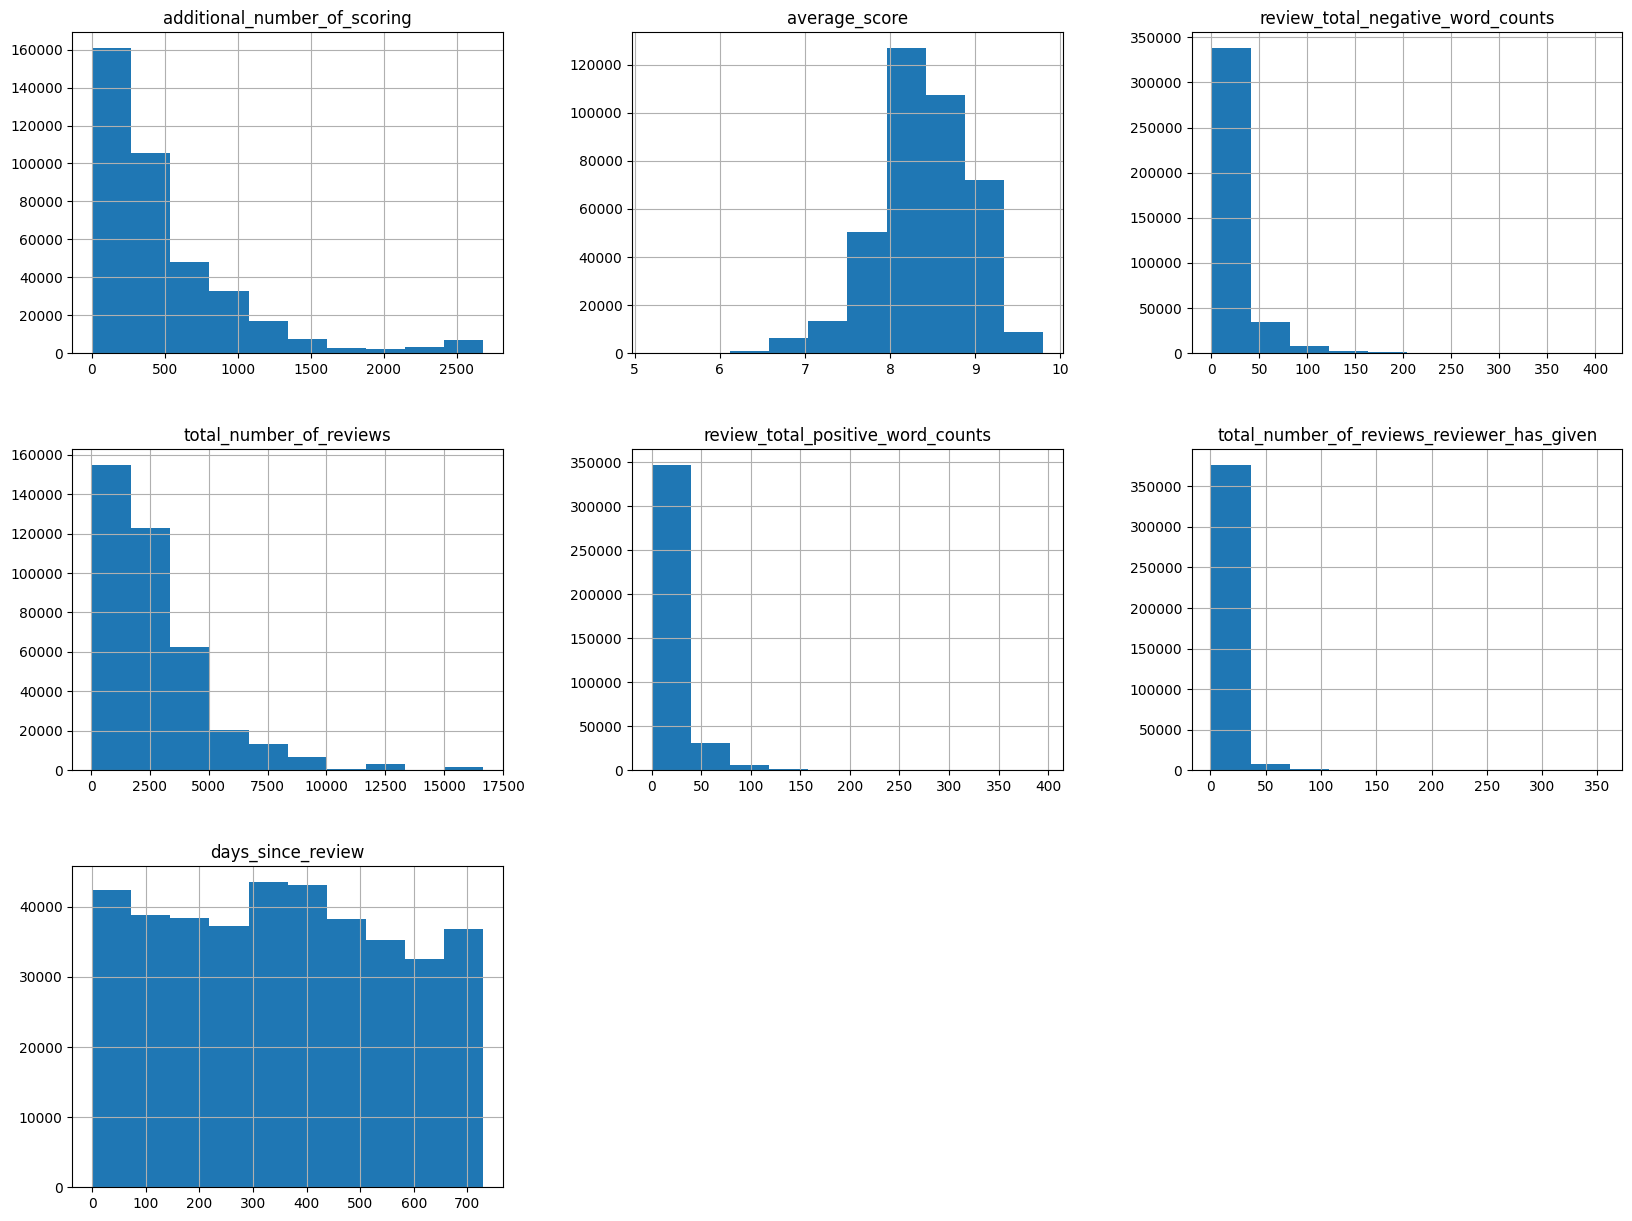

In [38]:
# посмотрим наглядно на распределение признаков
hotels[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews',
        'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']].hist(figsize = (20, 15));

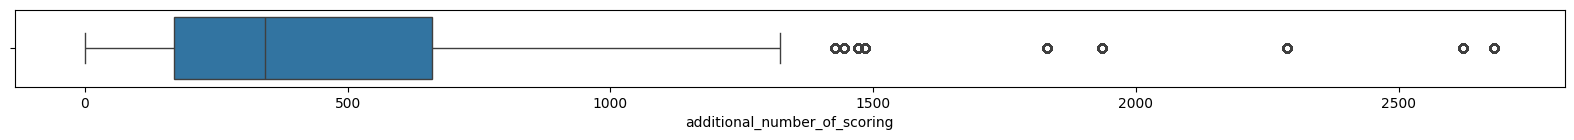

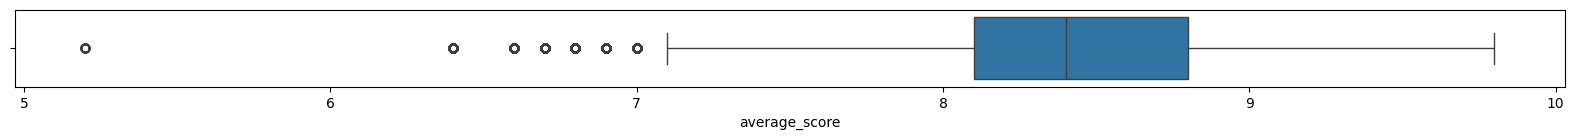

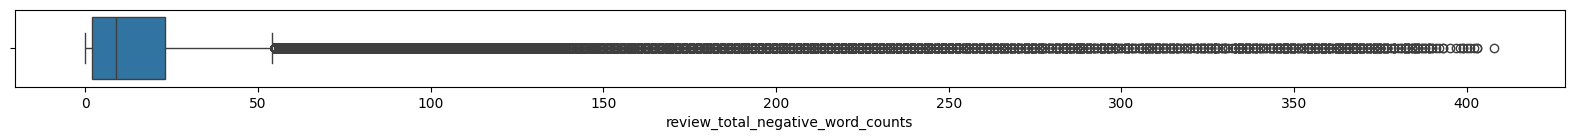

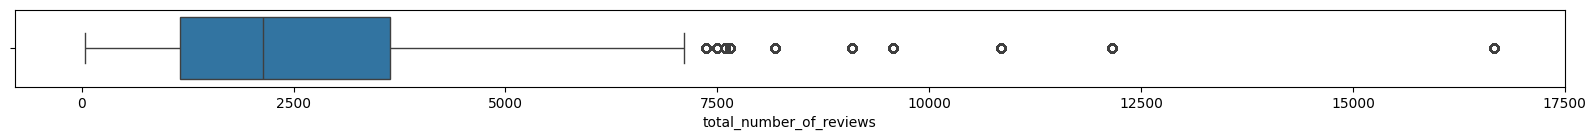

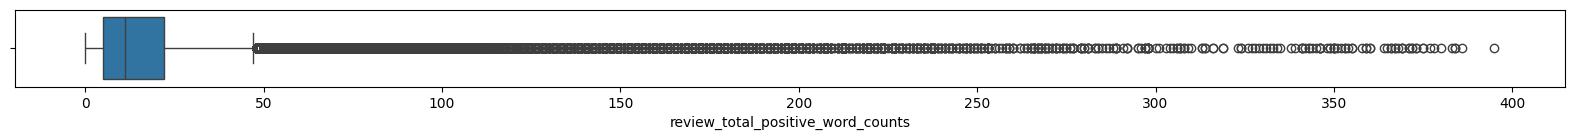

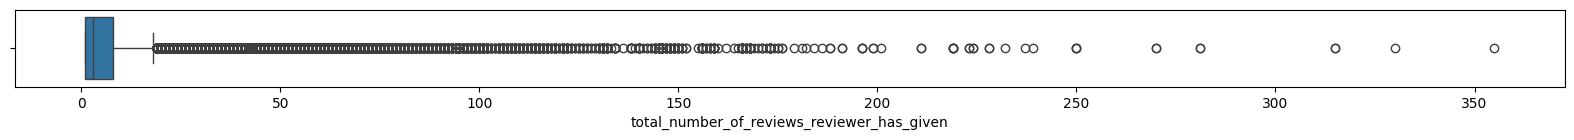

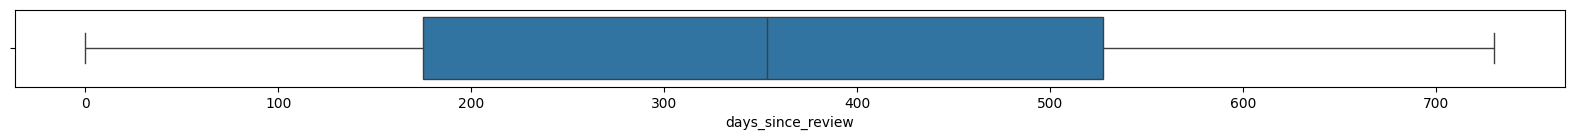

In [39]:
# список числовых непрерывных признаков 
list_numeric_features = hotels[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews',
        'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']]
# посмотрим на коробчатой диаграмме на выбросы в данных признаках
def get_outliers(lst):
    for feature in lst:
        fig = plt.figure(figsize=(20, 1))
        boxplot= sns.boxplot(
        data=hotels,
        x =feature,
        orient = 'h'
        )   
get_outliers(list_numeric_features)     

Мы видим, что ни один из признаков не имеет нормального распределения, все числовые признаки имеют выбросы, а некоторые показывают огромное количество выбросов.

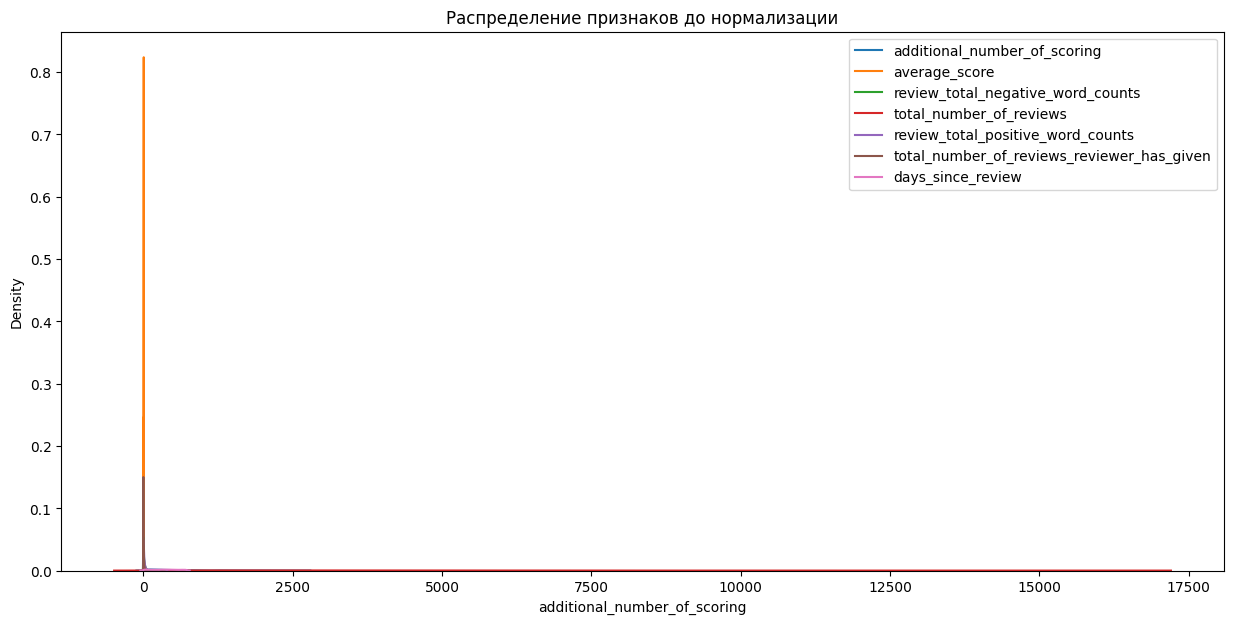

In [43]:
# визуализируем распределение на специальном графике kdeplot() (KDE – оценка плотности ядра)
fig, ax = plt.subplots(ncols=1, figsize=(15, 7))
ax.set_title('Распределение признаков до нормализации')
sns.kdeplot(hotels['additional_number_of_scoring'], ax=ax, label ='additional_number_of_scoring')
sns.kdeplot(hotels['average_score'], ax=ax, label ='average_score')
sns.kdeplot(hotels['review_total_negative_word_counts'], ax=ax, label ='review_total_negative_word_counts')
sns.kdeplot(hotels['total_number_of_reviews'], ax=ax, label = 'total_number_of_reviews')
sns.kdeplot(hotels['review_total_positive_word_counts'], ax=ax, label = 'review_total_positive_word_counts')
sns.kdeplot(hotels['total_number_of_reviews_reviewer_has_given'], ax=ax, label = 'total_number_of_reviews_reviewer_has_given')
sns.kdeplot(hotels['days_since_review'], ax=ax, label = 'days_since_review')
plt.legend();

Так как все признаки не имеют нормального распределения, мы подготовим признаки для нашей модели с помощью функций нормализации библиотеки sklearn.\
Коробчатая диаграмма показала, что признак *days_since_review* (количество дней с момента написания отзыва) менее всего подвержен аномальным выбросам, которые мы наблюдаем в других признаках. К данному признаку мы можем применить функцию масшабирования данных MinMaxScaler.\
К признакам *additional_number_of_scoring*, *average_score*, *review_total_negative_word_counts*, *total_number_of_reviews*, *review_total_positive_word_counts*, *total_number_of_reviews_reviewer_has_given* для нормализации данных подойдет функция RobustScaler, которая устойчива к выбросам.

In [44]:
days_scaler = preprocessing.MinMaxScaler()
hotels[['days_since_review']] = days_scaler.fit_transform(hotels[['days_since_review']])

In [45]:
feature_scaler = preprocessing.RobustScaler()
hotels[['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
         'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']] = feature_scaler.fit_transform(
             hotels[['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
         'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']]) 

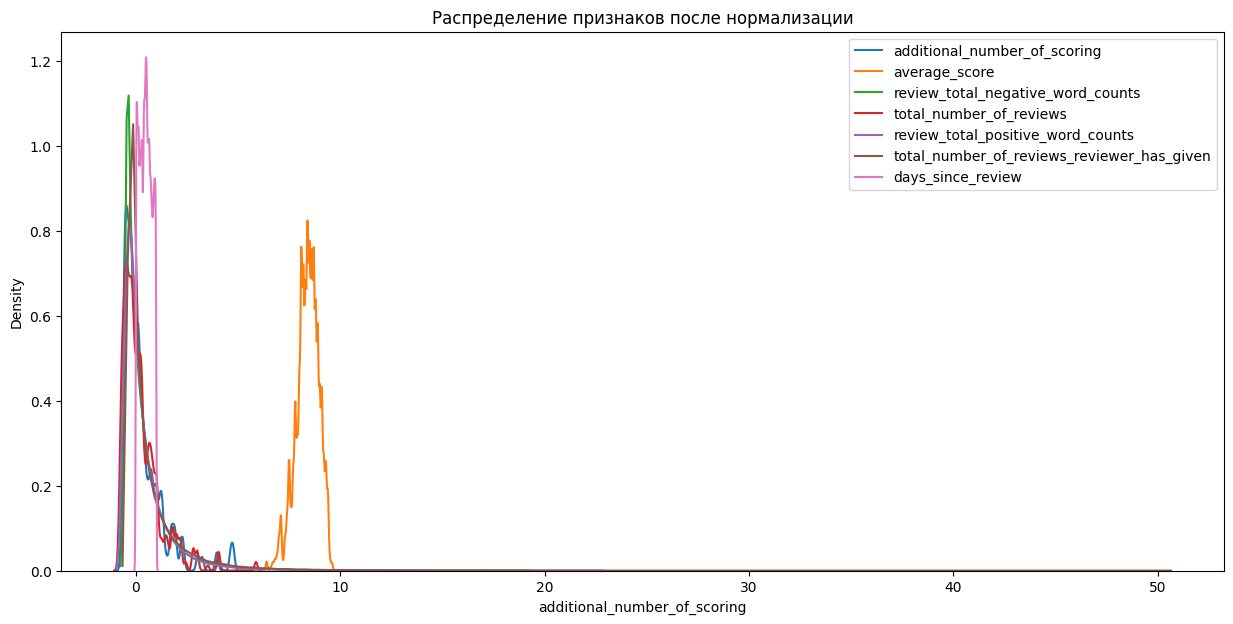

In [46]:
# теперь посмотрим на распределение после нормализации признаков
fig, ax = plt.subplots(ncols=1, figsize=(15, 7))
ax.set_title('Распределение признаков после нормализации')
sns.kdeplot(hotels['additional_number_of_scoring'], ax=ax, label ='additional_number_of_scoring')
sns.kdeplot(hotels['average_score'], ax=ax, label ='average_score')
sns.kdeplot(hotels['review_total_negative_word_counts'], ax=ax, label ='review_total_negative_word_counts')
sns.kdeplot(hotels['total_number_of_reviews'], ax=ax, label = 'total_number_of_reviews')
sns.kdeplot(hotels['review_total_positive_word_counts'], ax=ax, label = 'review_total_positive_word_counts')
sns.kdeplot(hotels['total_number_of_reviews_reviewer_has_given'], ax=ax, label = 'total_number_of_reviews_reviewer_has_given')
sns.kdeplot(hotels['days_since_review'], ax=ax, label = 'days_since_review')
plt.legend();

<font color='orange'>**Вывод:**</font>\
После нормализации признаков мы видим, что кривая kde приобрела очертания нормальности(куполообразности).

#### <font color='green'>**6. Отбор признаков.**</font>

1. Для отбора признаков проведем анализ мультиколлинеарности, что повысит качество прогнозирования модели. Если корреляция между признаками более 0.7 (-0.7), это показывает на сильную связь и приводит к мультиколлинеарности, отберем один из признаков.
2. Наши данные представлены двумя видами числовых признаков: категориальные(номинальные) и непрерывные. Проведем тесты для определения значимости признаков для модели: для оценки значимости категориальных признаков - тест хи-квадрат, для непрерывных признаков — тест ANOVA.

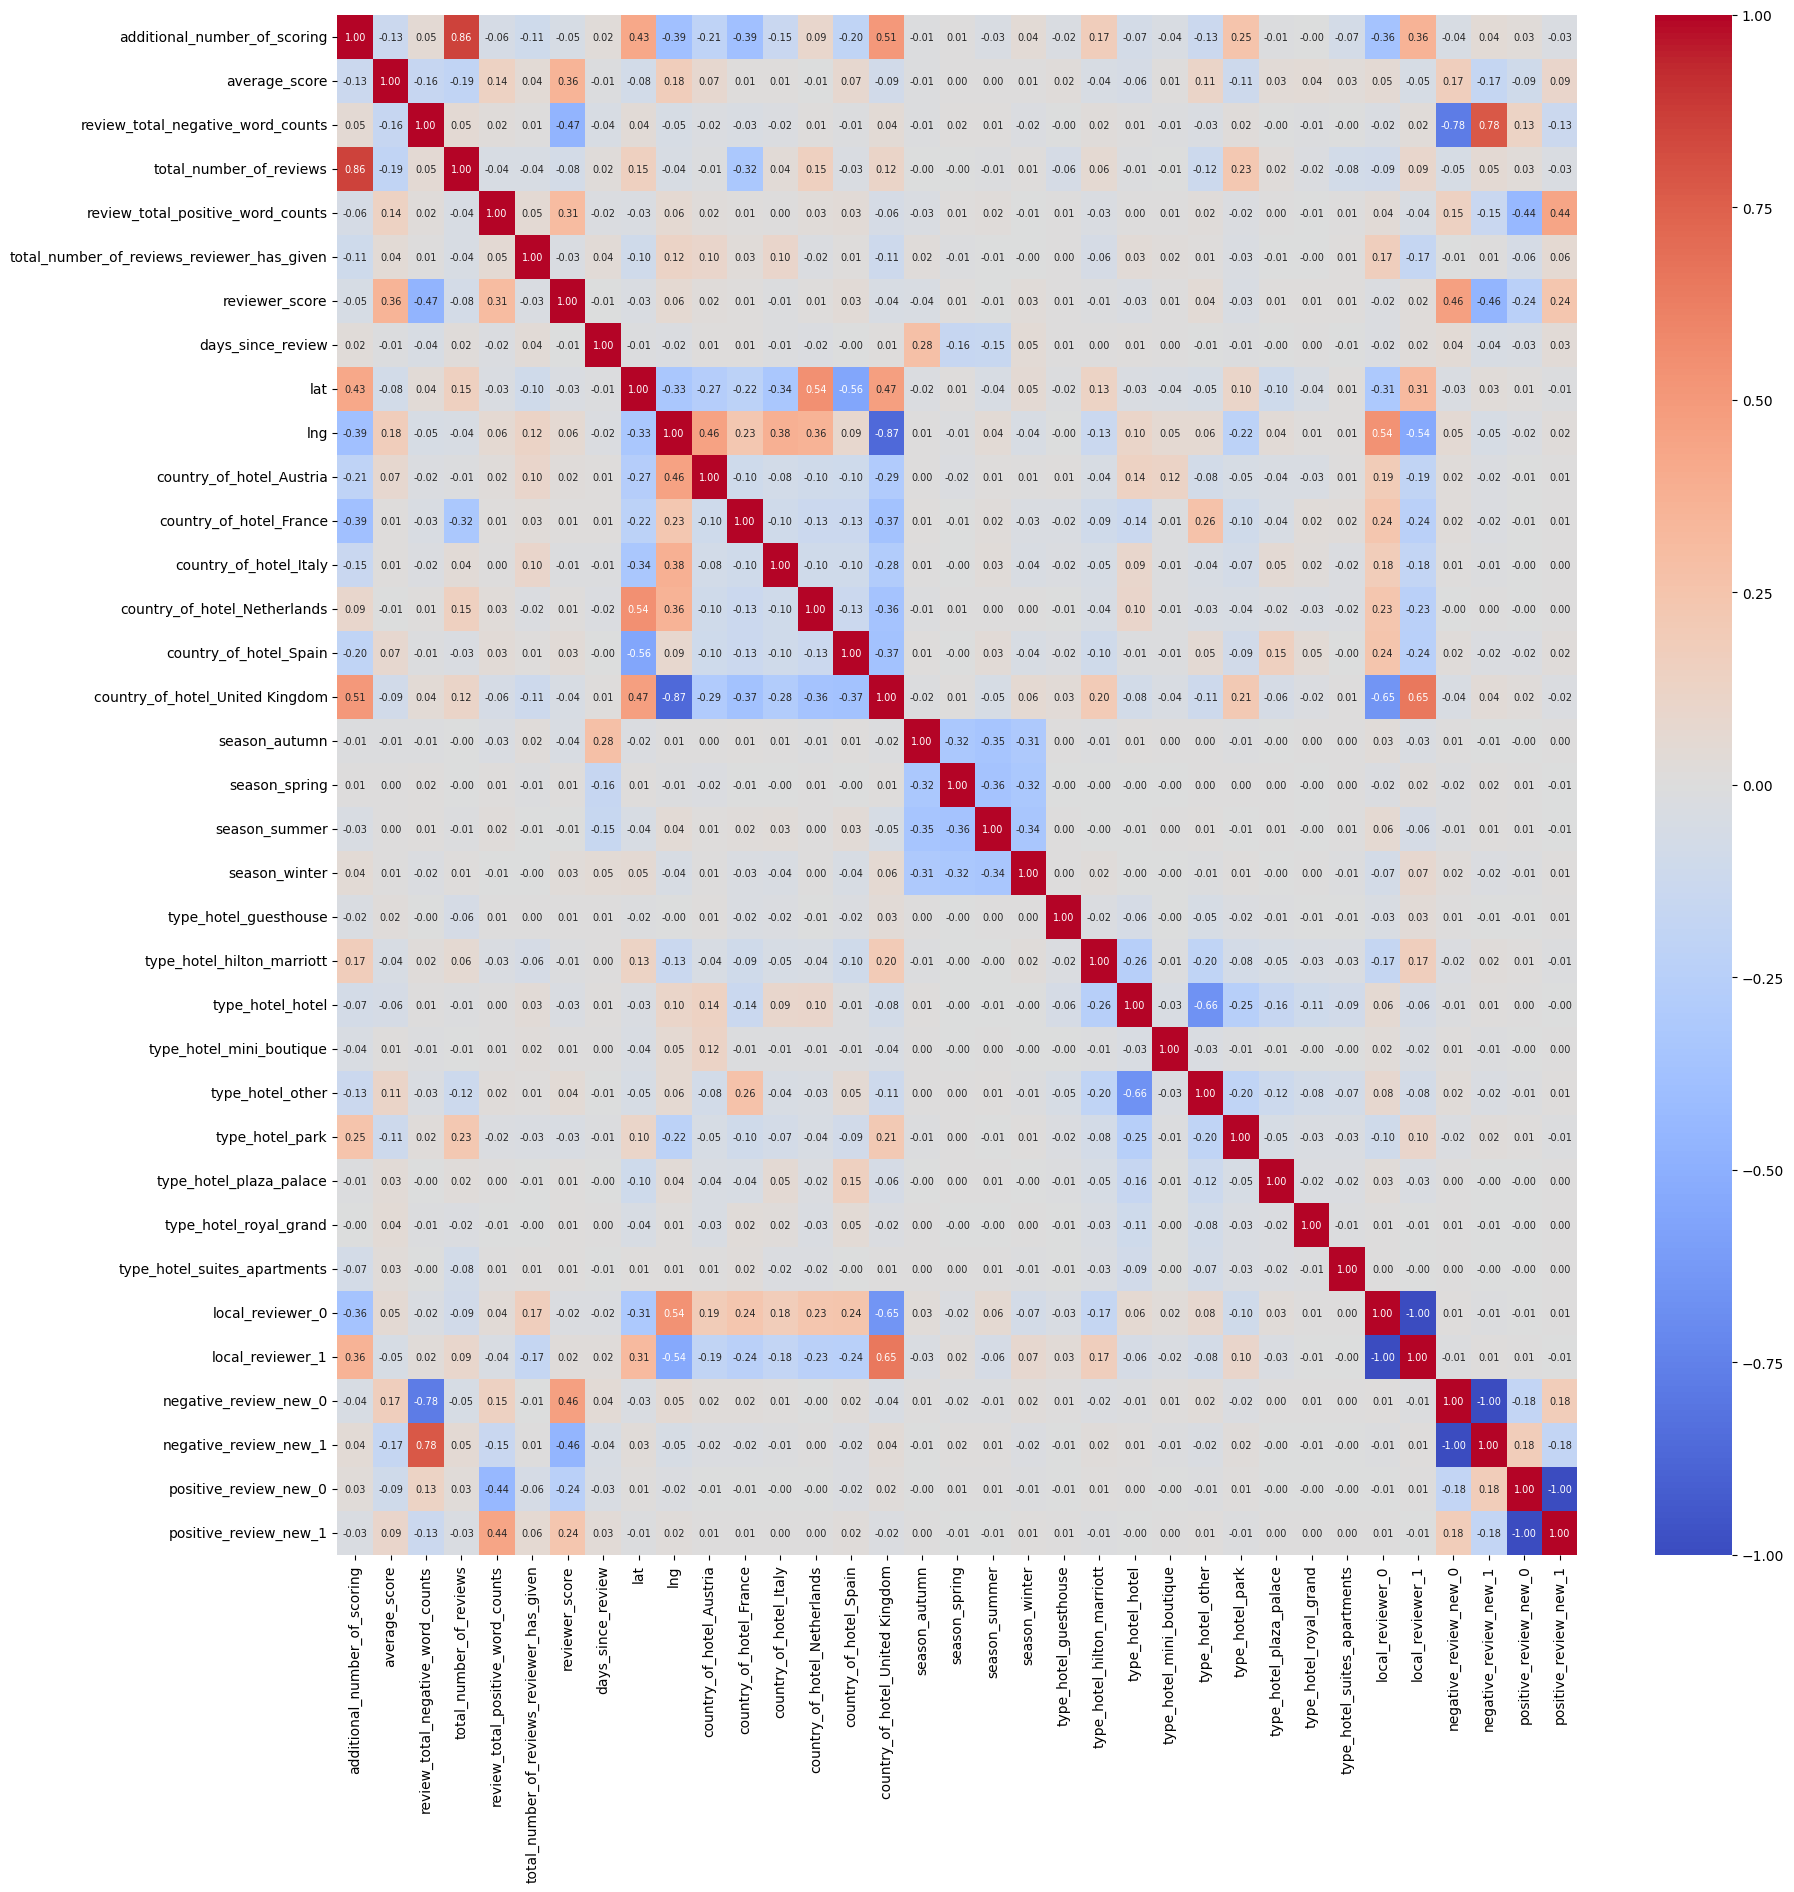

In [47]:
# тепловая карта корреляции признаков, применим метод Спирмена, который больше подходит для категориальных признаков, 
# но мы можем его применять и для числовых непрерывных признаков, не имеющих нормального распределения.
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(hotels.corr(method='spearman'), annot=True, fmt='.2f', annot_kws={'size':7}, cmap='coolwarm', ax=ax);

Проведем статистические тесты для определения значимости признаков перед созданием модели.

In [52]:
# непрерывные признаки
numeric_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts','total_number_of_reviews', 
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']

# категориальные признаки
categorical_cols = ['average_score', 'lat', 'country_of_hotel_Austria', 'country_of_hotel_France', 'country_of_hotel_Italy',
                    'country_of_hotel_Netherlands', 'country_of_hotel_Spain', 'country_of_hotel_United Kingdom', 'season_autumn',
                    'season_spring', 'season_summer', 'season_winter', 'type_hotel_hilton_marriott', 'type_hotel_hotel', 
                    'type_hotel_mini_boutique', 'type_hotel_other', 'type_hotel_park', 'type_hotel_plaza_palace',
                    'type_hotel_royal_grand', 'type_hotel_suites_apartments', 'type_hotel_guesthouse', 'local_reviewer_0',
                    'local_reviewer_1', 'negative_review_new_0', 'negative_review_new_1', 'positive_review_new_0', 'positive_review_new_1']

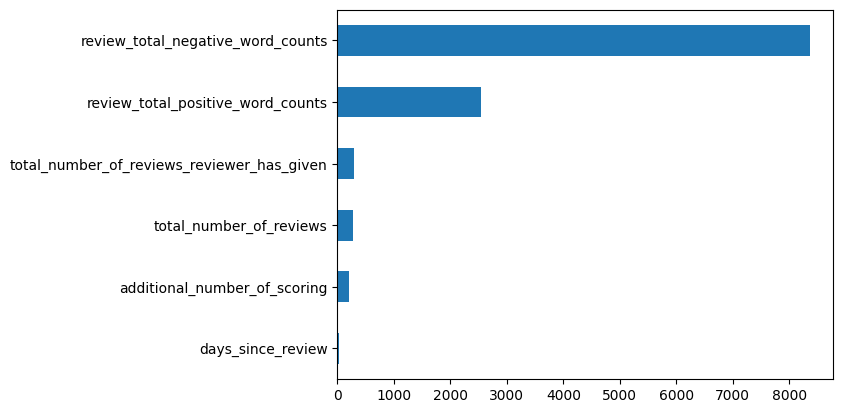

In [49]:
# наш ключевой признак reviewer_score, с которым анализируем взаимосвязь
y = hotels['reviewer_score'].astype('int')
'''
Для оценки значимости непрерывных данных используем функцию f_classif из библиотеки sklearn. 
В основе метода лежит статистический анализ ANOVA: обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).
Метод возвращает двумерный массив f-статистик и p-value для каждого признака. 
В качестве меры значимости мы будем использовать значение f-статистики. 
Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, 
и тем важнее данный признак для нашей модели. Отобразим значения на графике.
'''
numeric_features = pd.Series(f_classif(hotels[numeric_cols], y)[0], index = numeric_cols)
numeric_features.sort_values(inplace = True)
numeric_features.plot(kind = 'barh');

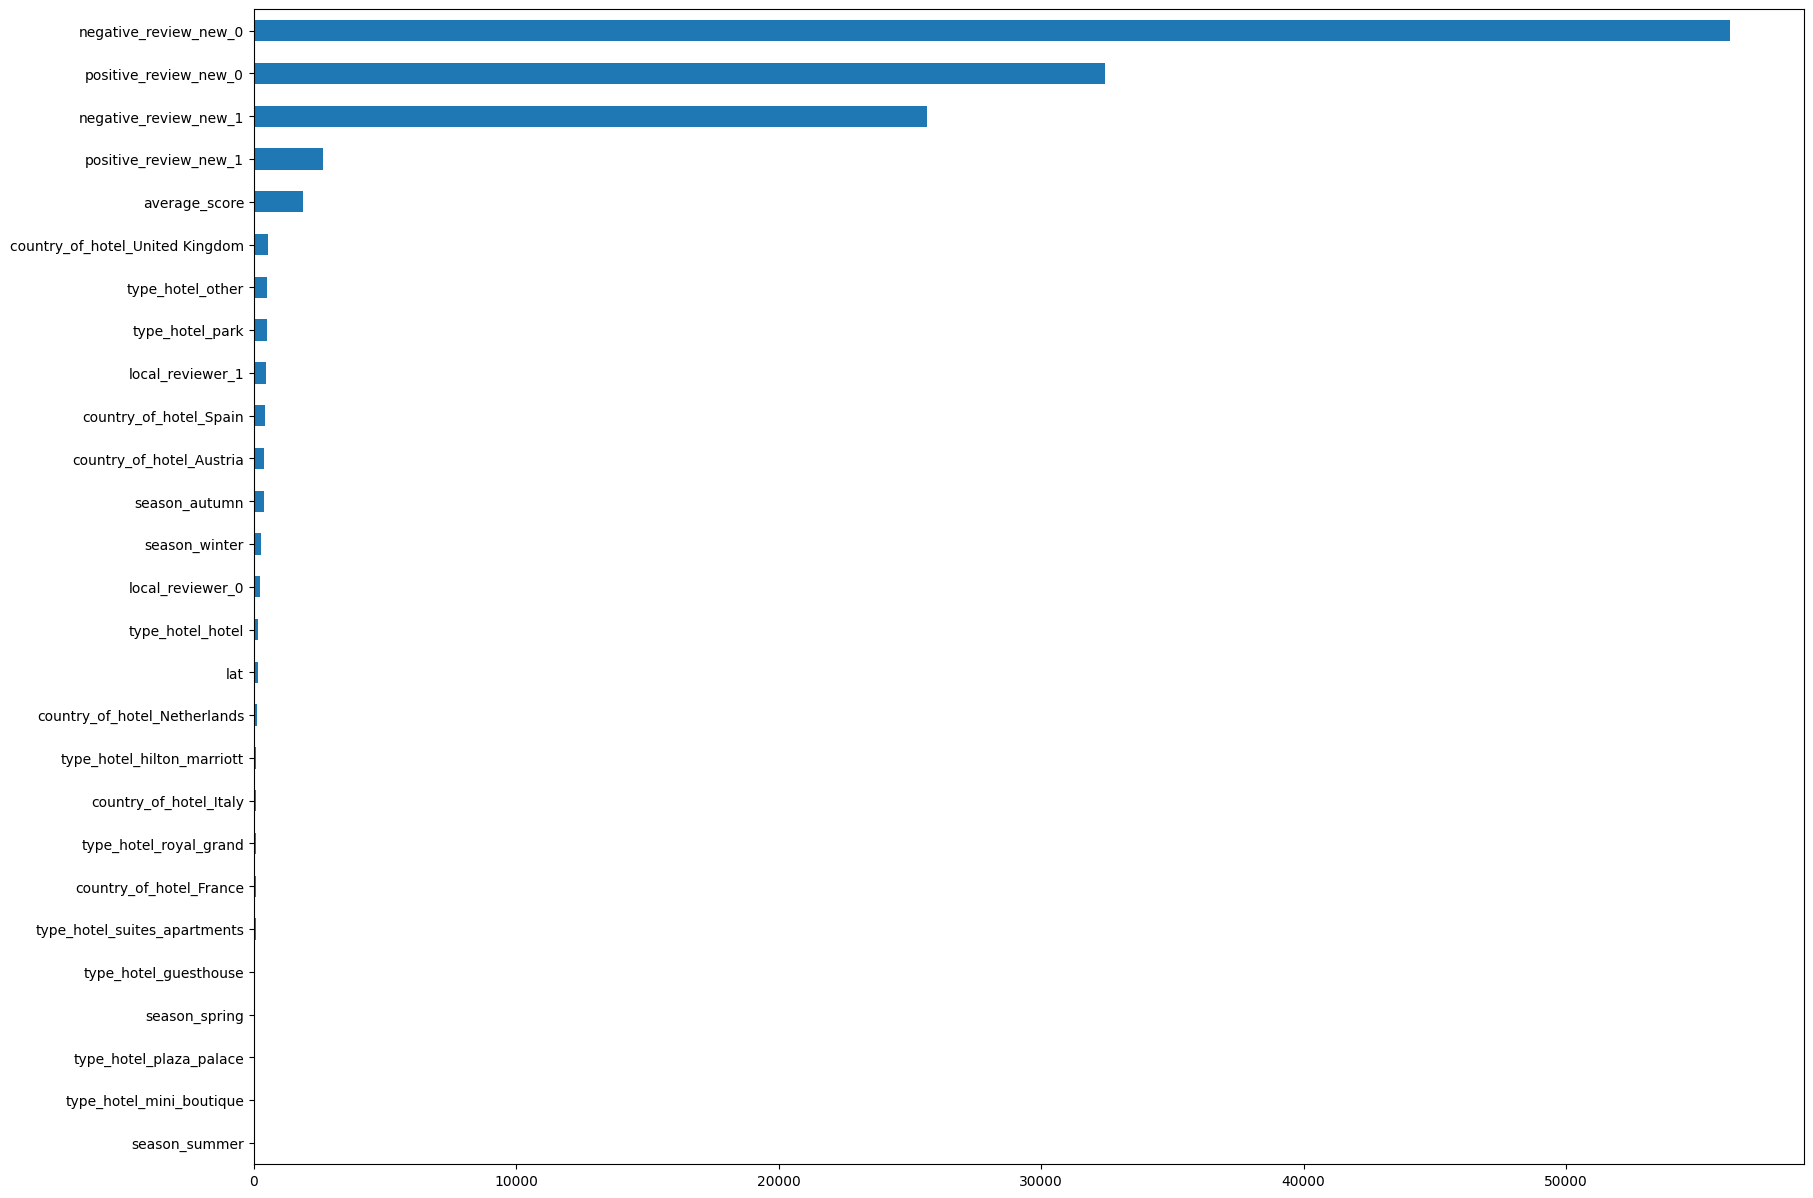

In [53]:
'''
Для оценки значимости категориальных переменных используем непараметрический тест хи-квадрат, 
реализованный функцией библиотеки sklearn.feature_selection.chi2. 
Метод возвращает массив значений хи-квадрат и p-value для каждого признака. 
Используем только значения хи-квадрат и выведем их на графике.
'''
categorical_features = pd.Series(chi2(hotels[categorical_cols], y)[0], index = categorical_cols)
categorical_features.sort_values(inplace = True)
categorical_features.plot(kind = 'barh', figsize=(20,15));

<font color='orange'>**Вывод:**</font>\
Тепловая карта корреляции выявила мультиколлинеарность у следующих признаков:
* additional_number_of_scoring и total_number_of_reviews,
* review_total_negative_word_counts и negative_review_new,
* lng и country_of_hotel_United_Kingdom - эту связь мы однозначно понимаем, как 'ложная' корреляция (в силу абсурдности).

По результатам статистических тестов мы наблюдаем самую низкую значимость у таких признаков, как:
* days_since_review, 
* additional_number_of_scoring менее значим, чем total_number_of_reviews,
* признаки сезонности season_spring, season_summer,
* признаки типа отеля type_hotel_suites_apartments, type_hotel_guesthouse, type_hotel_mini_boutique, 
type_hotel_plaza_palace, type_hotel_hilton_marriott, type_hotel_royal_grand,
* признаки стран отелей country_of_hotel_France, country_of_hotel_Italy, country_of_hotel_Netherlands.

Признаки review_total_negative_word_counts и negative_review_new показывают мультиколлинеарность, но по результатам тестов 
они имеют высокую значимость, значит, ни один из этих признаков мы удалять не будем.

Список признаков на исключение:
1. additional_number_of_scoring;
2. season_spring, season_summer;
3. days_since_review;
4. type_hotel_suites_apartments, type_hotel_guesthouse, type_hotel_mini_boutique, 
type_hotel_plaza_palace, type_hotel_hilton_marriott, type_hotel_royal_grand;
5. признаки стран country_of_hotel_France, country_of_hotel_Italy, country_of_hotel_Netherlands.

<font color='orange'>**Для начала мы создадим нашу модель и обучим ее на всех признаках и посмотрим на процент ошибки при прогнозах, а затем исключим выделенные признаки и посмотрим на результат проверки модели в сравнении.**</font>

#### <font color='green'>**7. Создание модели, тестирование.**</font>

In [69]:
# создадим копию датасета для второй модели
hotels_droped = hotels.copy()

<font color='orange'>**1. Модель первая со всеми признаками датафрейма**</font>

In [67]:
# разбиваем датасет на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [60]:
# датафрейм с меткой "train" используем для обучения модели, "test" - для тестирования.  
# для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
# создаём модель  
model = RandomForestRegressor(n_estimators=100)  
      
# обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train)  
      
# используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test)  

# cравним предсказанные значения (y_pred) с реальными (y_test) и посмотрим, насколько они отличаются  
# используем метрику mape c помощью атрибута metrics из библиотеки sklearn
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
print('Средняя абсолютная процентная ошибка MAPE:', mape)

Средняя абсолютная процентная ошибка MAPE: 13.499


In [61]:
display(hotels.shape)
hotels_droped.shape

(386496, 35)

(386496, 35)

<font color='orange'>**2. Модель вторая с исключением некоторых признаков датафрейма**</font>

In [70]:
# исключение признака days_since_review ухудшает точность прогнозов, оставим его
# удалим признак долготы lng, показавший мультиколлинеарность
hotels_droped.drop(['type_hotel_suites_apartments', 'type_hotel_guesthouse', 'type_hotel_mini_boutique', 
                    'type_hotel_plaza_palace', 'type_hotel_hilton_marriott', 'type_hotel_royal_grand', 'country_of_hotel_France', 
                    'country_of_hotel_Italy', 'additional_number_of_scoring', 'lng', 'lat', 'season_spring', 'season_summer'], axis=1, inplace=True)
X_2 = hotels_droped.drop(['reviewer_score'], axis = 1)  
y_2 = hotels_droped['reviewer_score'] 
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=42)
model_2 = RandomForestRegressor(n_estimators=100)  
model_2.fit(X_train_2, y_train_2)  
y_pred_2 = model_2.predict(X_test_2)  
mape_2 = round(metrics.mean_absolute_percentage_error(y_test_2, y_pred_2) * 100, 3)
print('Средняя абсолютная процентная ошибка MAPE:', mape_2)

Средняя абсолютная процентная ошибка MAPE: 13.487


#### <center><font color='orange'>**Заключение**</font></center>

1. Мы достигли нашей цели  - средняя абсолютная процентная ошибка MAPE модели 13,5%, это с учетом включения всех преобразованных признаков.
2. При исключении признаков с низкой значимостью и мультиколлинеарностью результат модели более точен. Можно экспериментировать с исключением разных признаков и проверки прогноза. 
3. Но прежде всего, на точность и качество модели влияет наличие информативных признаков, так как мы исключили из модели самый объемный признак(теги), вы можете его преобразовать во множество информативных признаков и дополнить датасет, а возможно сделать модель более точной.

<font color='blue'>**Примечание**</font>\
Пишите идеи и коды по созданию новых признаков для данной модели.
Я не дополняла модель новыми признаками из вне, какие идеи вы можете предложить...